# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [2]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

from sklearn.decomposition import PCA
from more_itertools import locate

In [3]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

C:\Users\yxiao977\AppData\Local\Temp\ipykernel_7448\1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


# ***Q1:***
- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


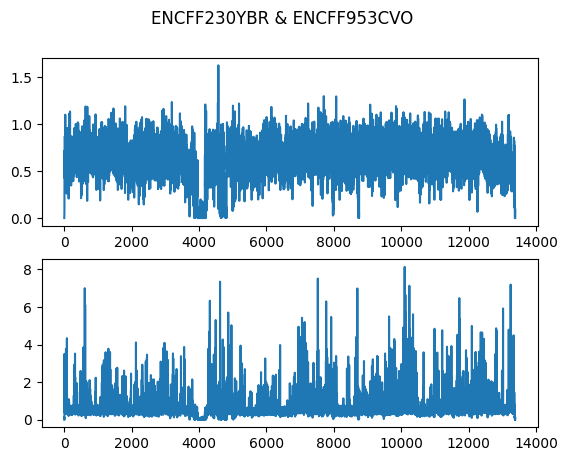

In [4]:
fig, axs = plt.subplots(2)
fig.suptitle('ENCFF230YBR & ENCFF953CVO')
axs[0].plot(df.ENCFF230YBR)
axs[1].plot(df.ENCFF953CVO)

C:\Users\yxiao977\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


<AxesSubplot: >

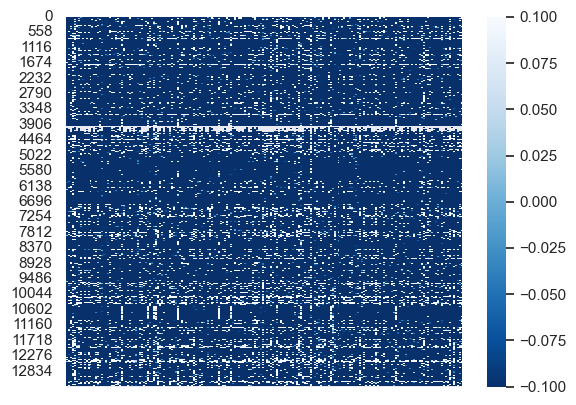

In [5]:
import seaborn as sns; sns.set()

sns.heatmap(np.log2(df[df.columns[3:]]), cmap="Blues_r", xticklabels=[])  # log2 transform is used to visualize differences better

# ***Q1 Answer:***
- The centromere of chromosomes are challenging to sequence because of their repetitive nature, and for chromosome 10 (chrom 10), the position of its centromere is around 40MB (39.8 Mbp). This could be the reason for many signals to dip on chr10 at around 40Mb. 

# ***Q2:***
- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


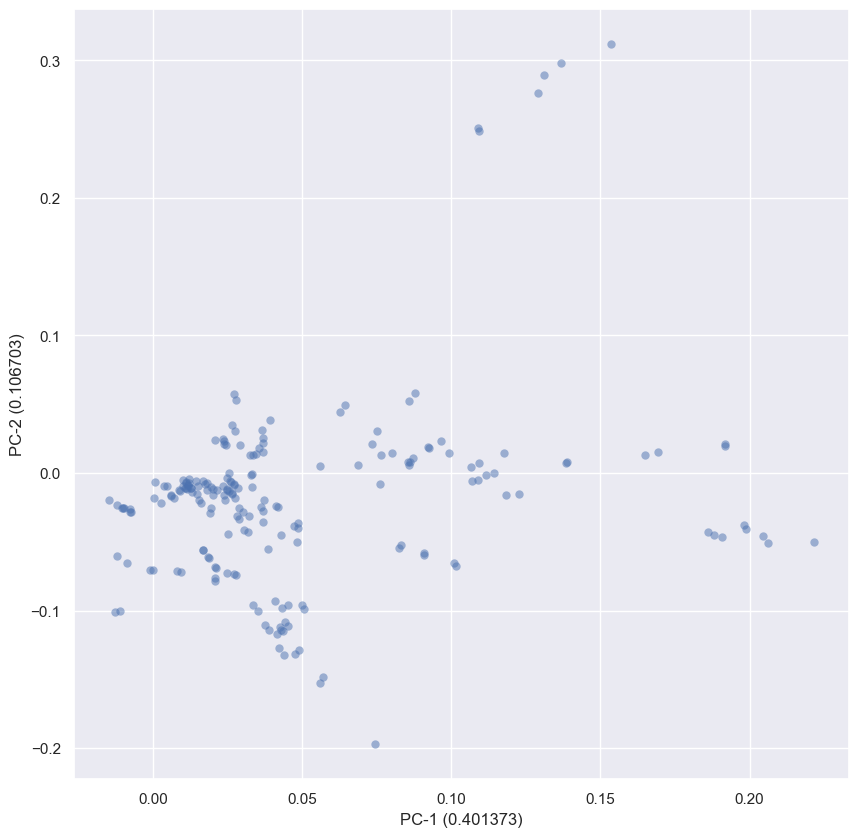

In [6]:
X = df.loc[:,~df.columns.isin(['chrom','start','end'])]
pca = PCA().fit(X)
plot_pca(pca, figsize=(10,10))

# pcdf = pd.DataFrame(data = pca, columns = ['PC-1', 'PC-2'])
# plt.figure(figsize=(16, 16), dpi=50)
# plt.scatter(pcdf['PC-1'],pcdf['PC-2'])
# plt.title("PCA plot (variance ratio)")
# plt.xlabel("PC-1 (%f)" % pca.explained_variance_ratio_[0])
# plt.ylabel("PC-2 (%f)" % pca.explained_variance_ratio_[1])

# ***Q3:***
- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

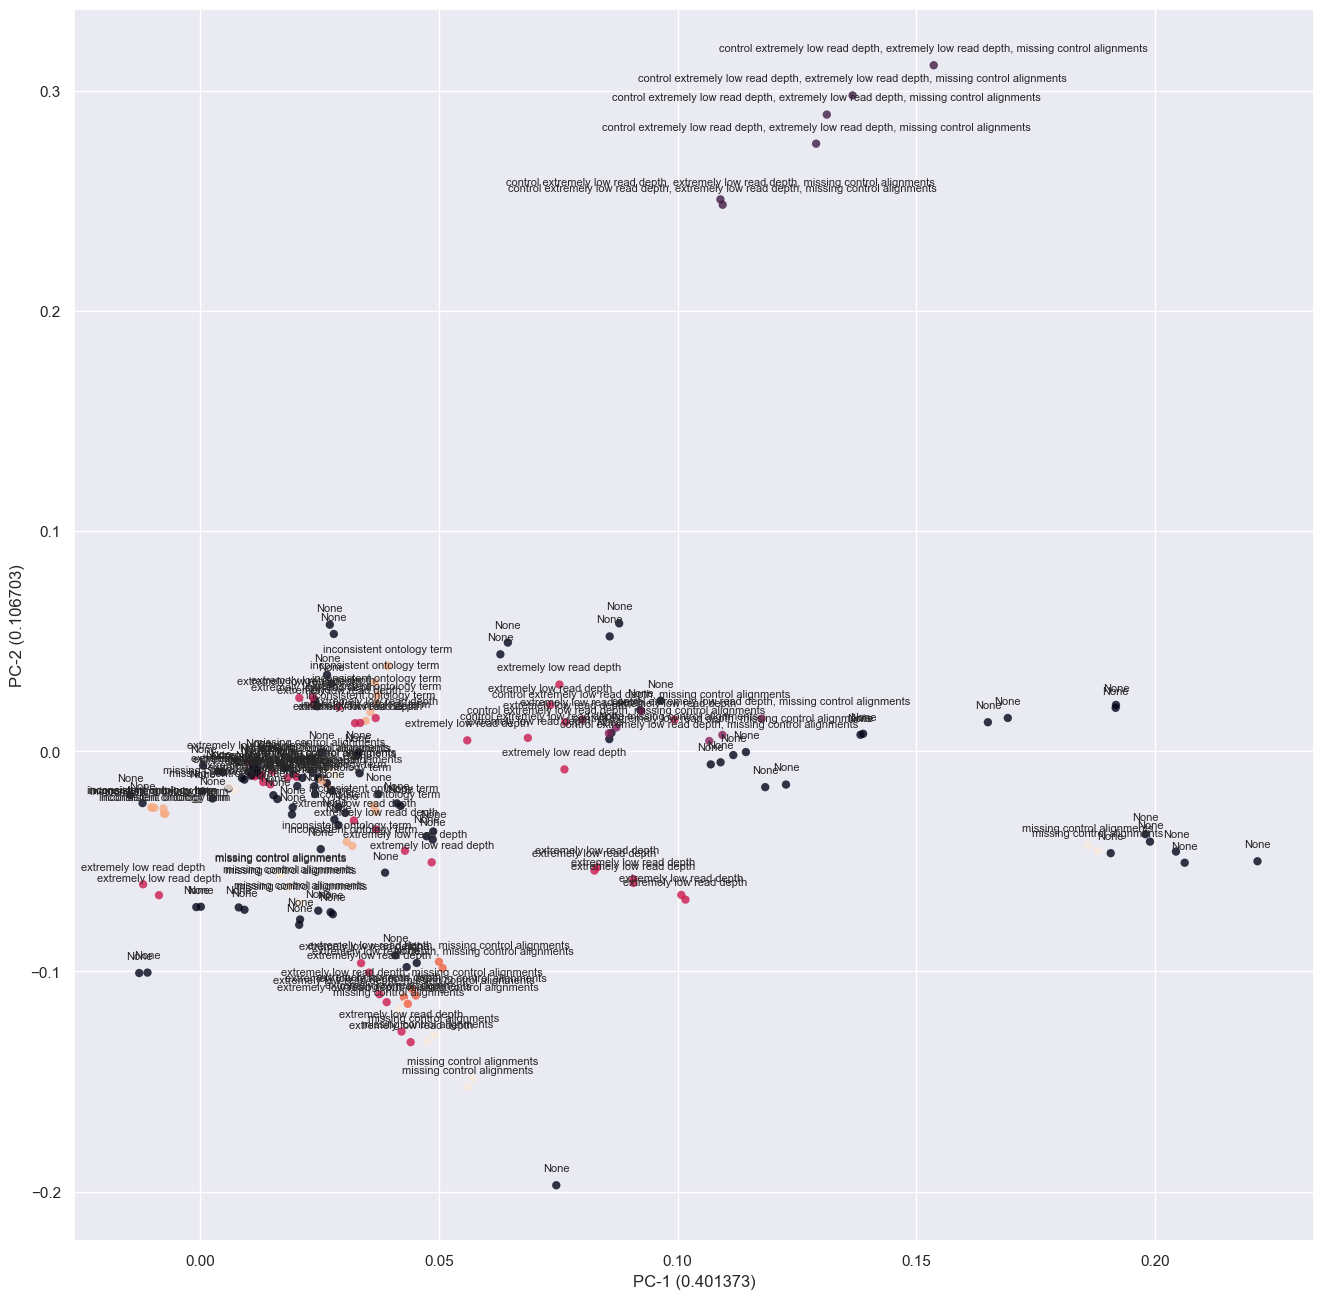

In [7]:
# display(bigwig_metadata.columns)
plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Audit ERROR", label_display=True, figsize=(16,16), alpha=0.8)

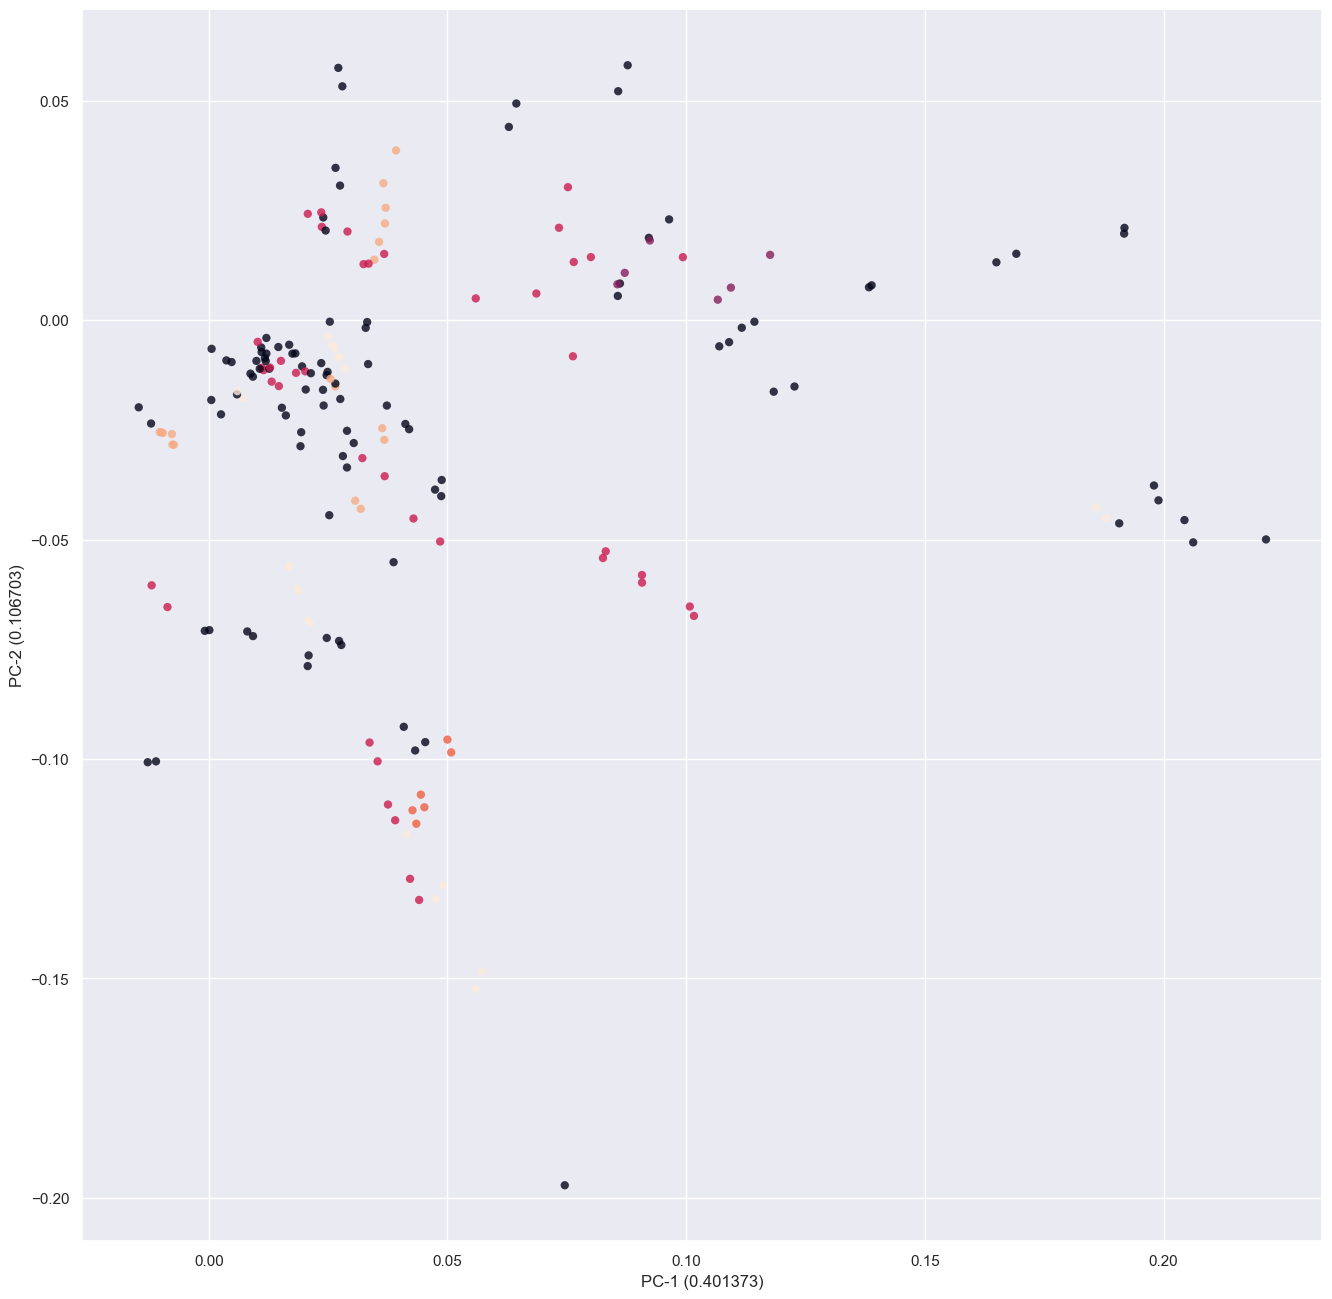

In [8]:
plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Audit ERROR", label_display=False, figsize=(16,16), alpha=0.8,
        filter_label_column="Audit ERROR",
        filterby="control extremely low read depth, extremely low read depth, missing control alignments")

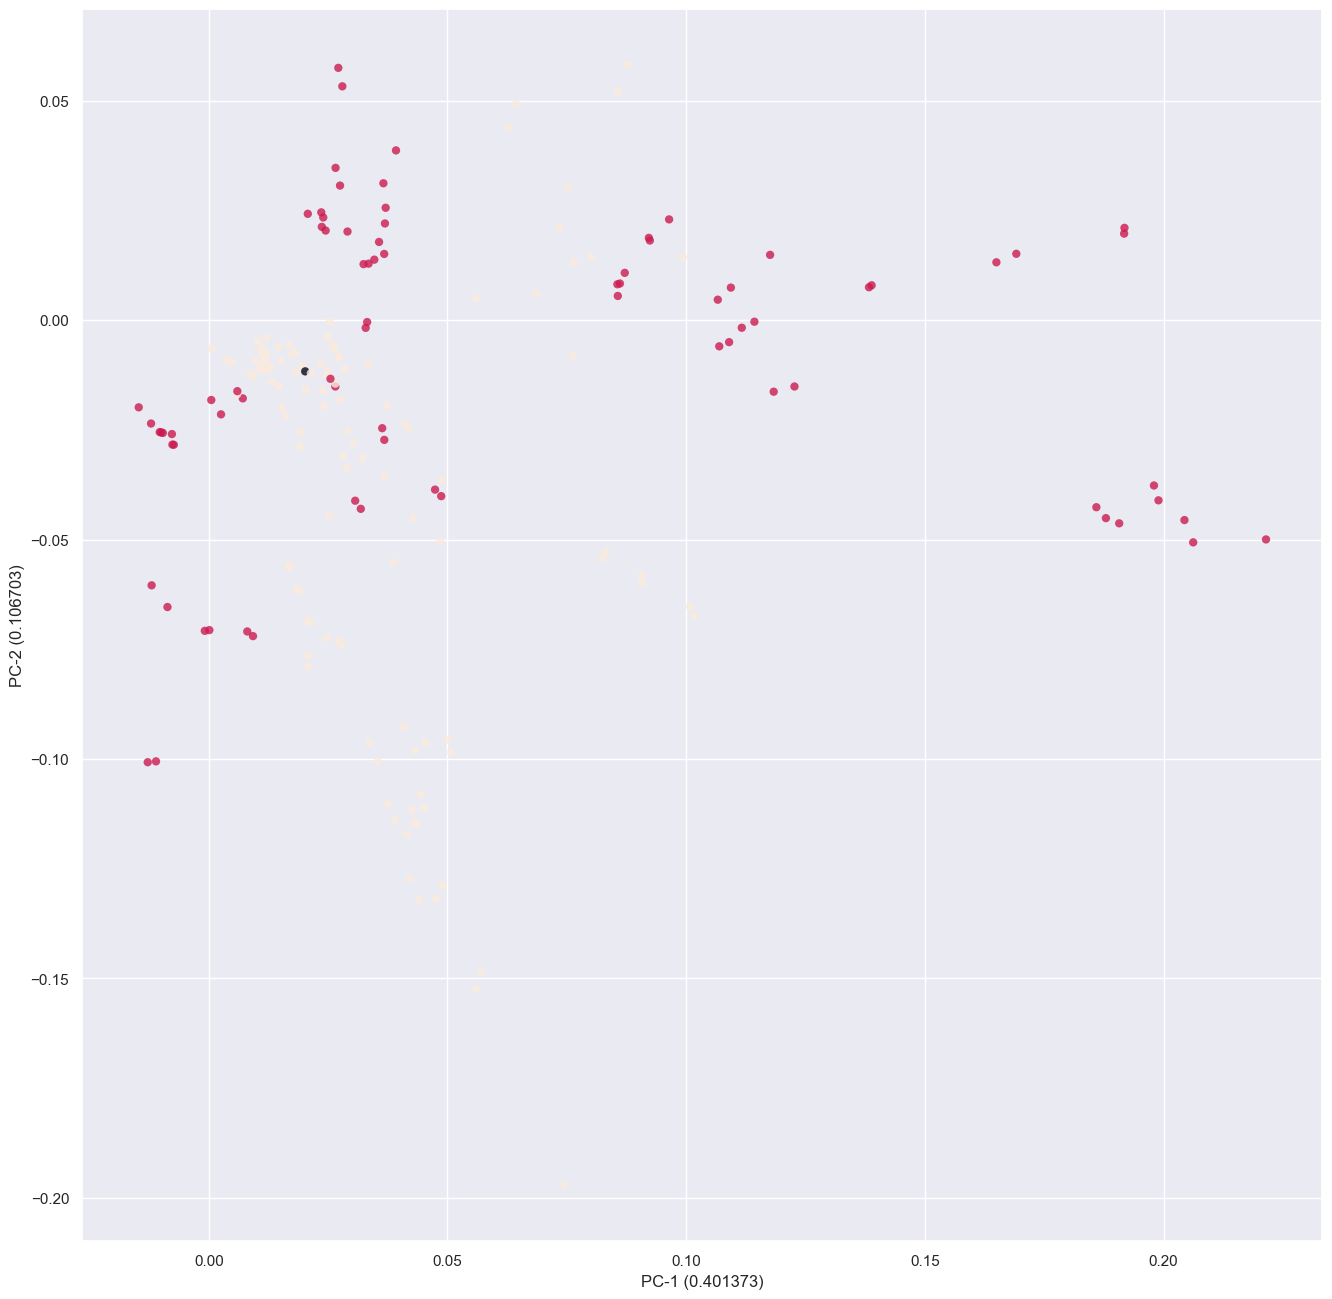

In [9]:
plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Assay", label_display=False, figsize=(16,16), alpha=0.8,
        filter_label_column = "Audit ERROR",
        filterby="control extremely low read depth, extremely low read depth, missing control alignments")

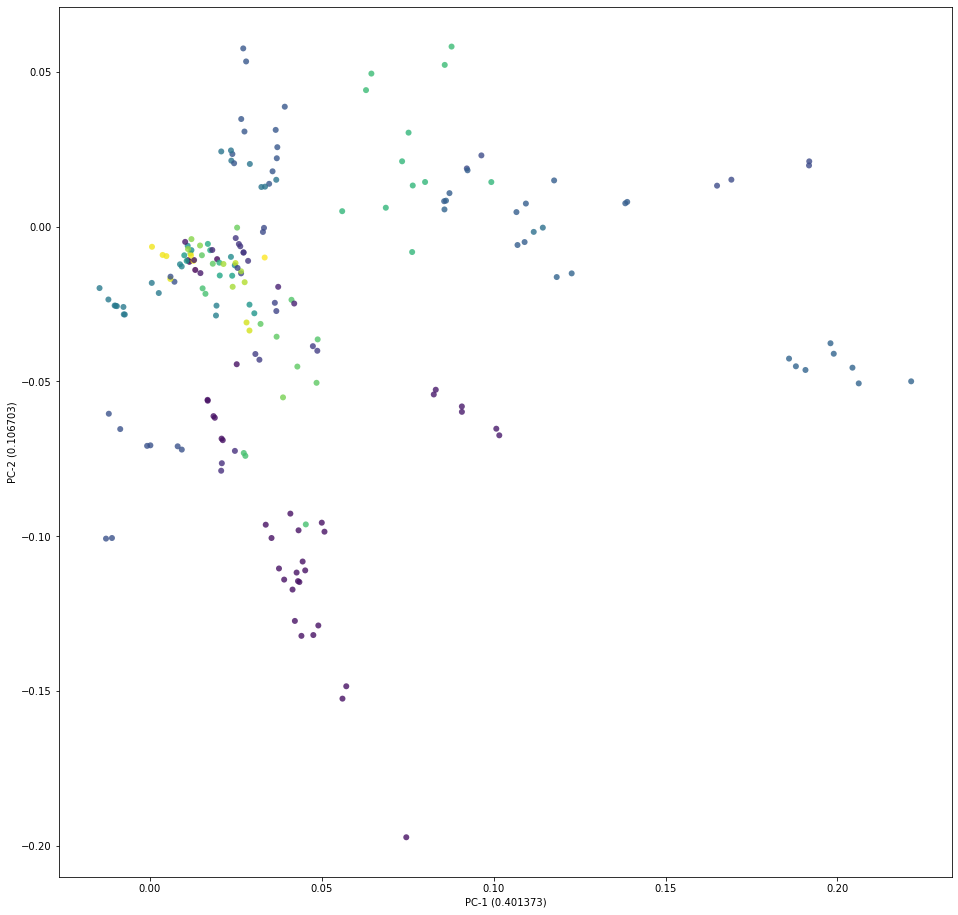

In [11]:
plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Experiment target", label_display=False, figsize=(16,16), alpha=0.8,
        filter_label_column = "Audit ERROR",
        filterby="control extremely low read depth, extremely low read depth, missing control alignments")


In [10]:
clean_bigwig = bigwig_metadata[bigwig_metadata['Audit ERROR'] != 'control extremely low read depth, extremely low read depth, missing control alignments']
filter_bigwig = clean_bigwig[clean_bigwig['File accession'].isin(df.columns[3:])]
df = df.loc[:, df.columns.isin(filter_bigwig['File accession'])]

# ***Q4:***
- Which Assays or Experiment Targets show broad vs narrow patterns ***with respect to genomic position?*** Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


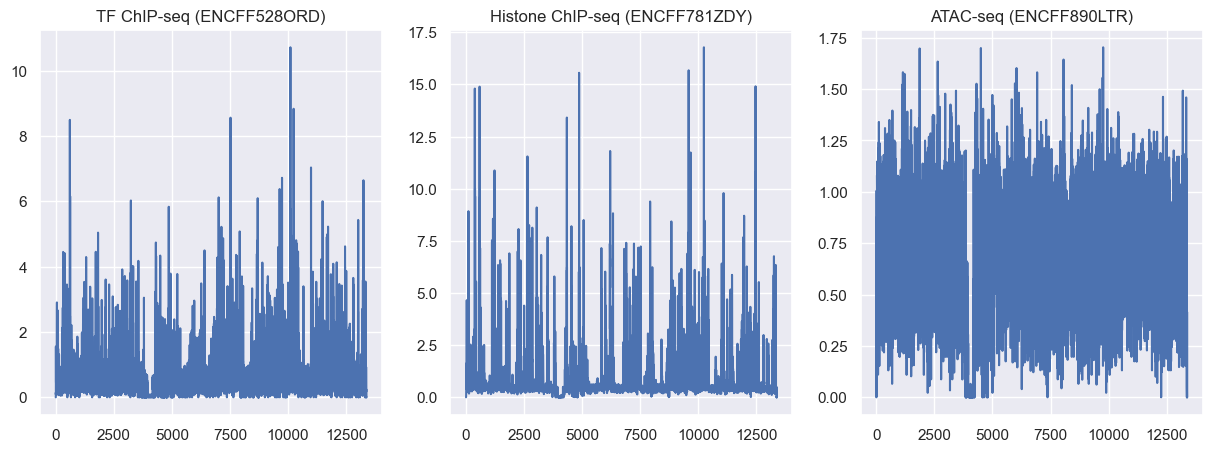

In [53]:
fig1, axs1 = plt.subplots(1,3, figsize = (15,5))
for i in range(3):
    f = filter_bigwig[filter_bigwig['Assay']== (filter_bigwig['Assay'].unique()[i])].iloc[0, 1]
    temp = df.loc[:,df.columns == f]
    axs1[i].plot(temp)
    axs1[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")



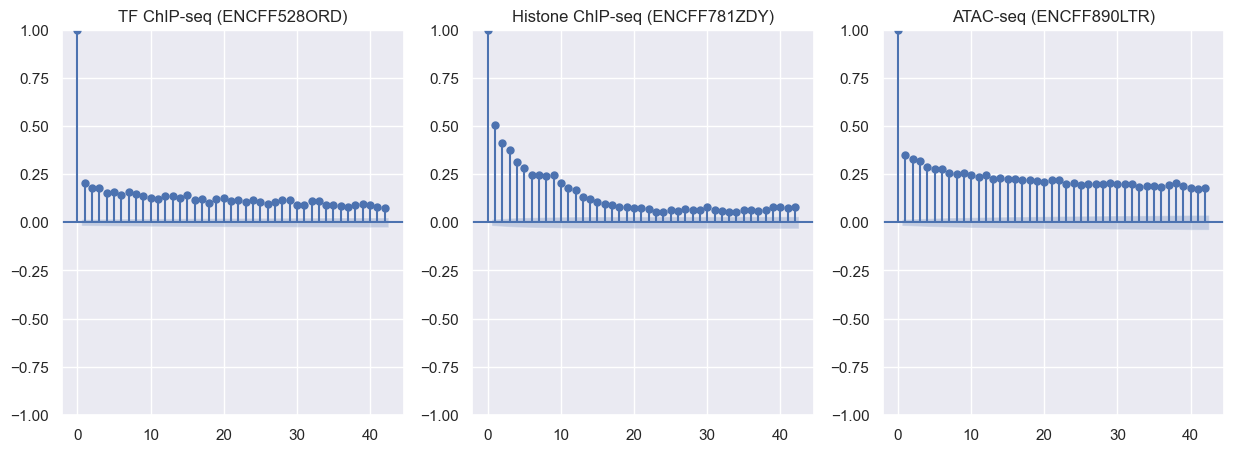

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

fig1, axs1 = plt.subplots(1,3, figsize = (15,5))
acorr = []
for i in range(3):
    f =  filter_bigwig[filter_bigwig['Assay']== (filter_bigwig['Assay'].unique()[i])].iloc[0, 1]
    temp = df.loc[:,df.columns == f]
    # # Mean
    # mean = np.mean(temp)

    # # Variance
    # var = np.var(temp)

    # # Normalized data
    # ndata = temp - mean
    # ndata = ndata.iloc[:,0]

    # acorr_temp = np.correlate(ndata, ndata, 'full')[(len(ndata)-1):] 
    # acorr.append(acorr_temp / var[0] / len(ndata))

    plot_acf(temp, ax=axs1[i])
    # axs1[i].plot(acorr[i])
    axs1[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")
    


    

<AxesSubplot: >

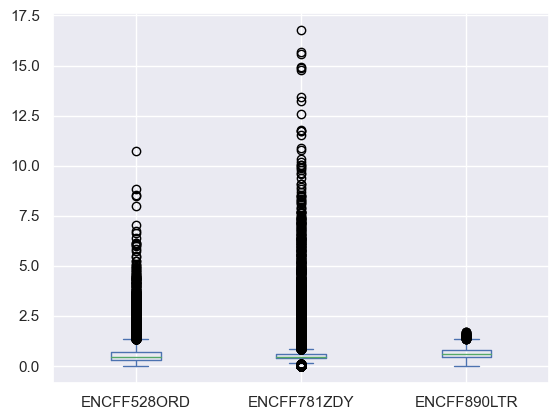

In [14]:
sample_list = [filter_bigwig[filter_bigwig['Assay'] == (filter_bigwig['Assay'].unique()[i])].iloc[0, 1] for i in range(3)]
df_temp = df[sample_list]
df_temp.plot(kind='box')

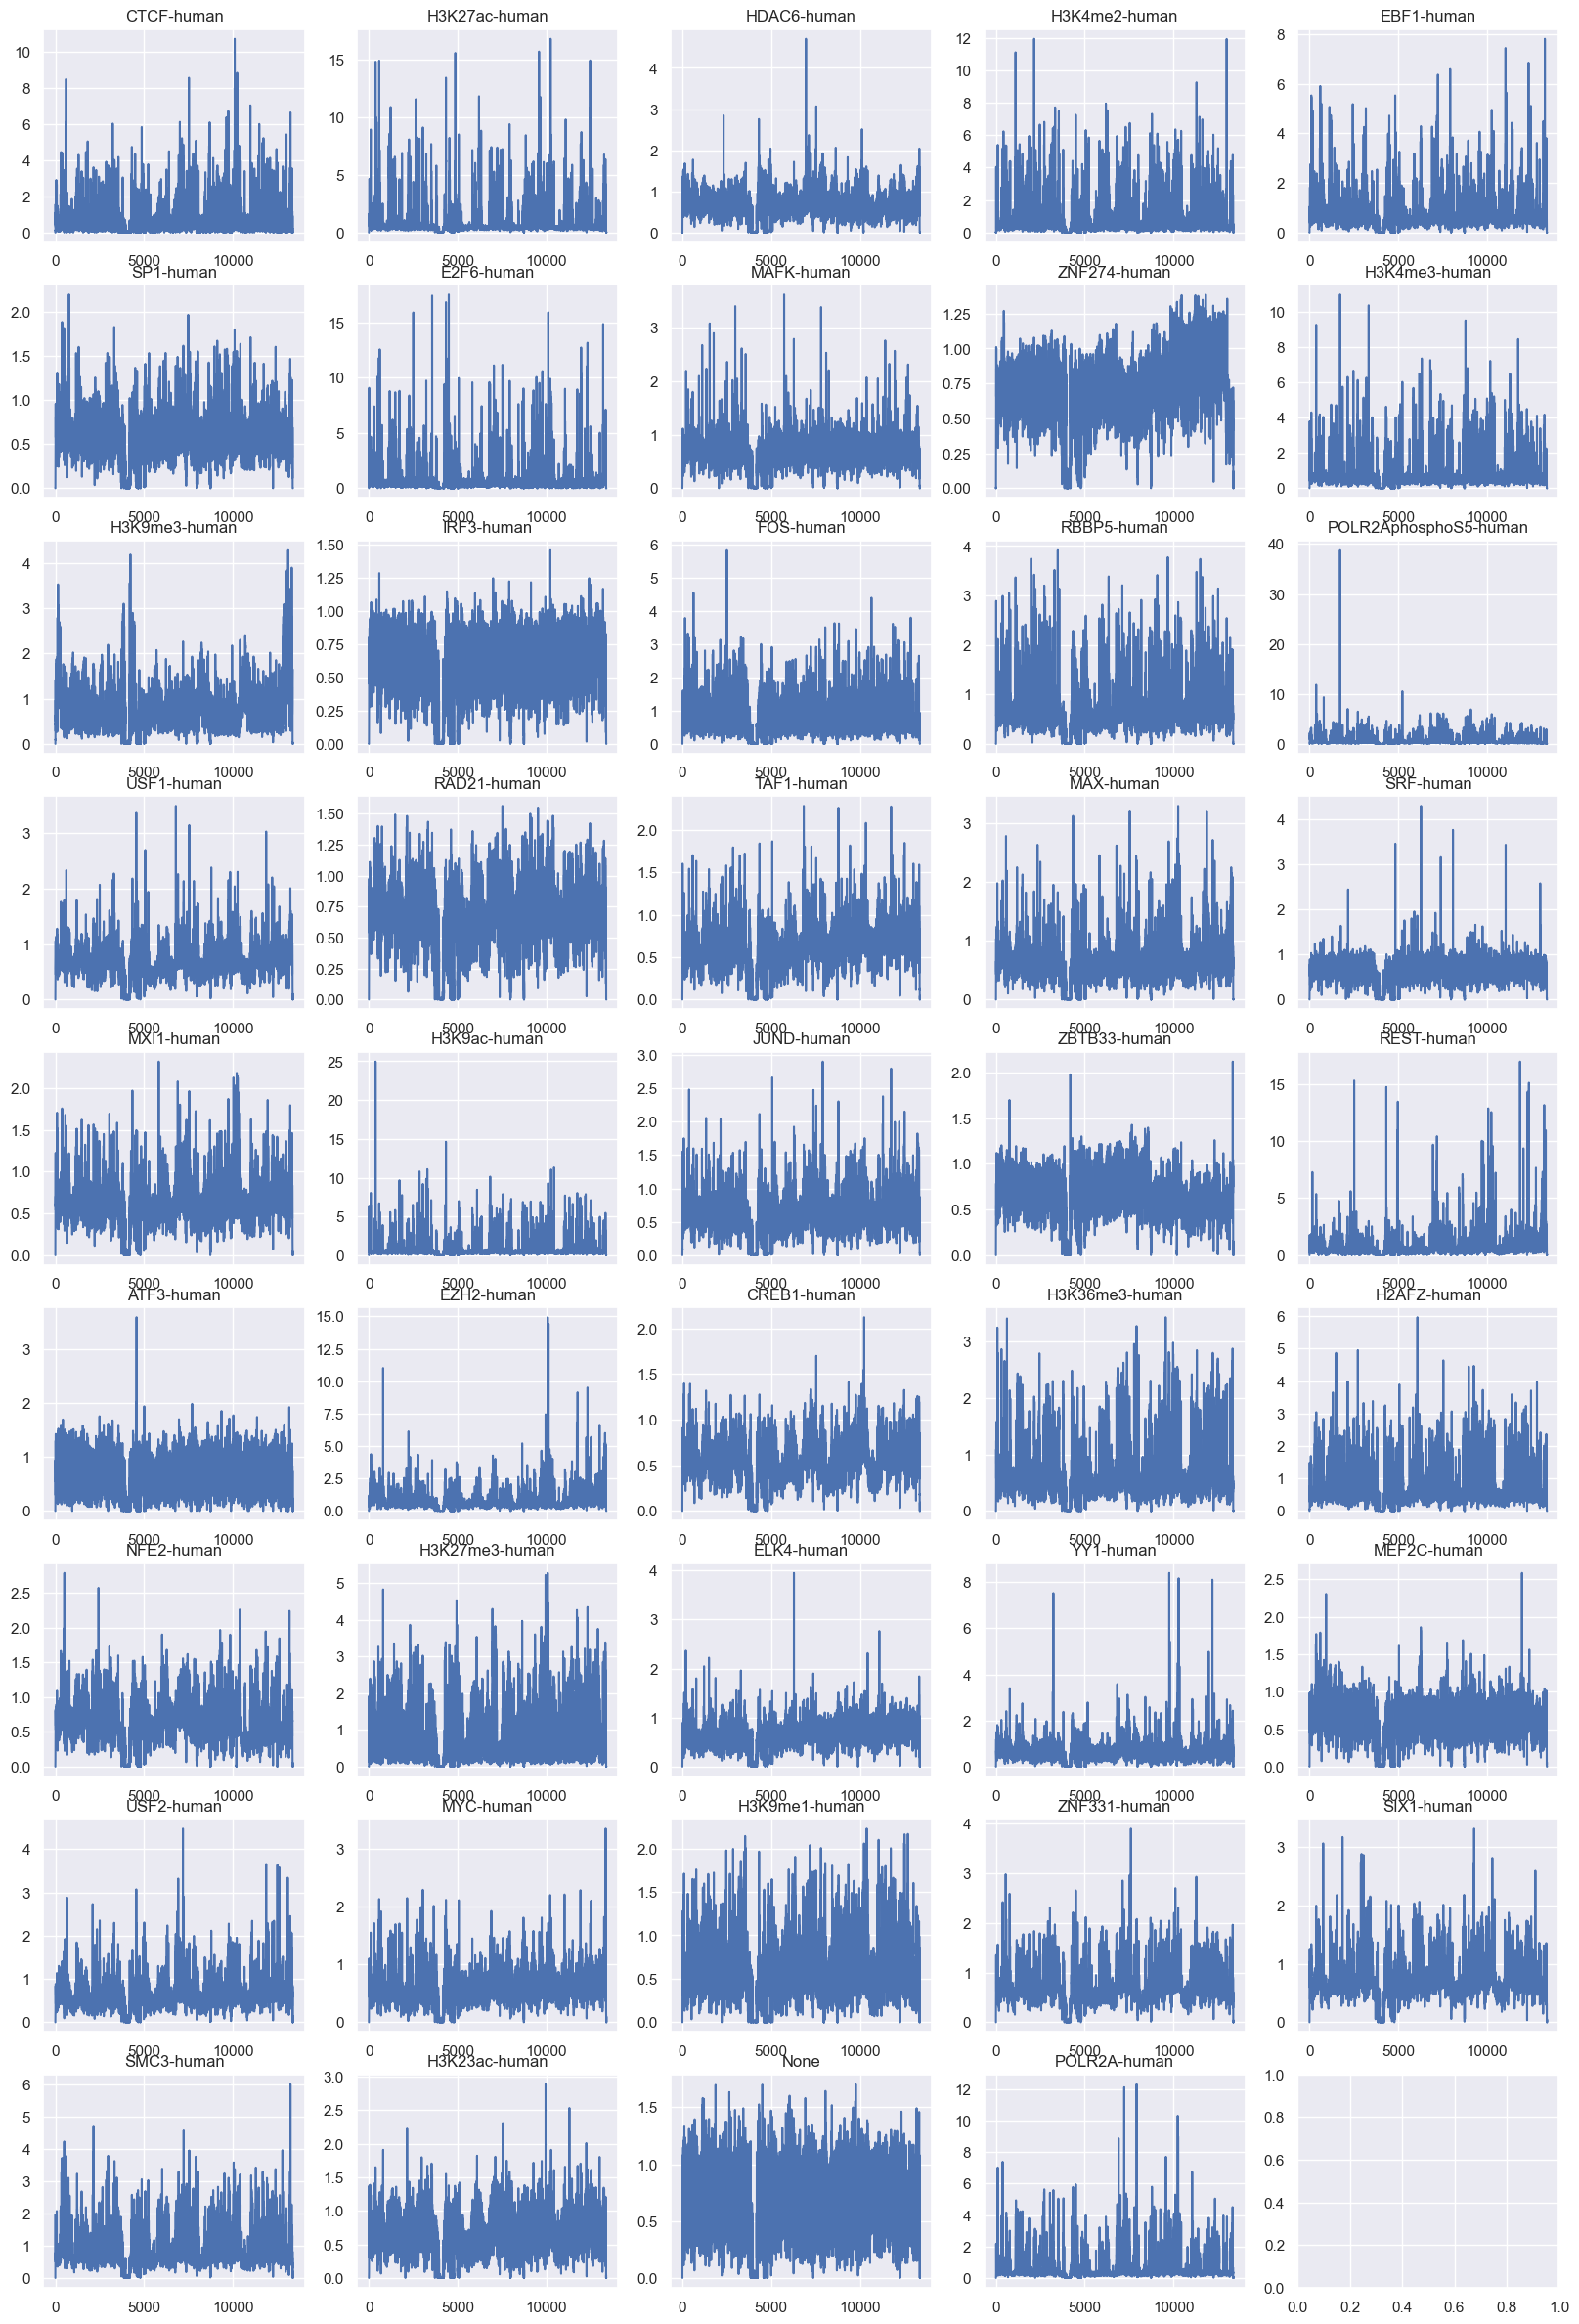

In [15]:
fig1, axs1 = plt.subplots(9, 5, figsize = (20,30))
for i in range(44):
    f = filter_bigwig[filter_bigwig['Experiment target']== (filter_bigwig['Experiment target'].unique()[i])].iloc[0, 1]
    temp = df.loc[:,df.columns == f]
    axs1[np.floor(i/5).astype(int),i % 5].plot(temp)
    axs1[np.floor(i/5).astype(int),i % 5].set_title(filter_bigwig['Experiment target'].unique()[i])


<AxesSubplot: >

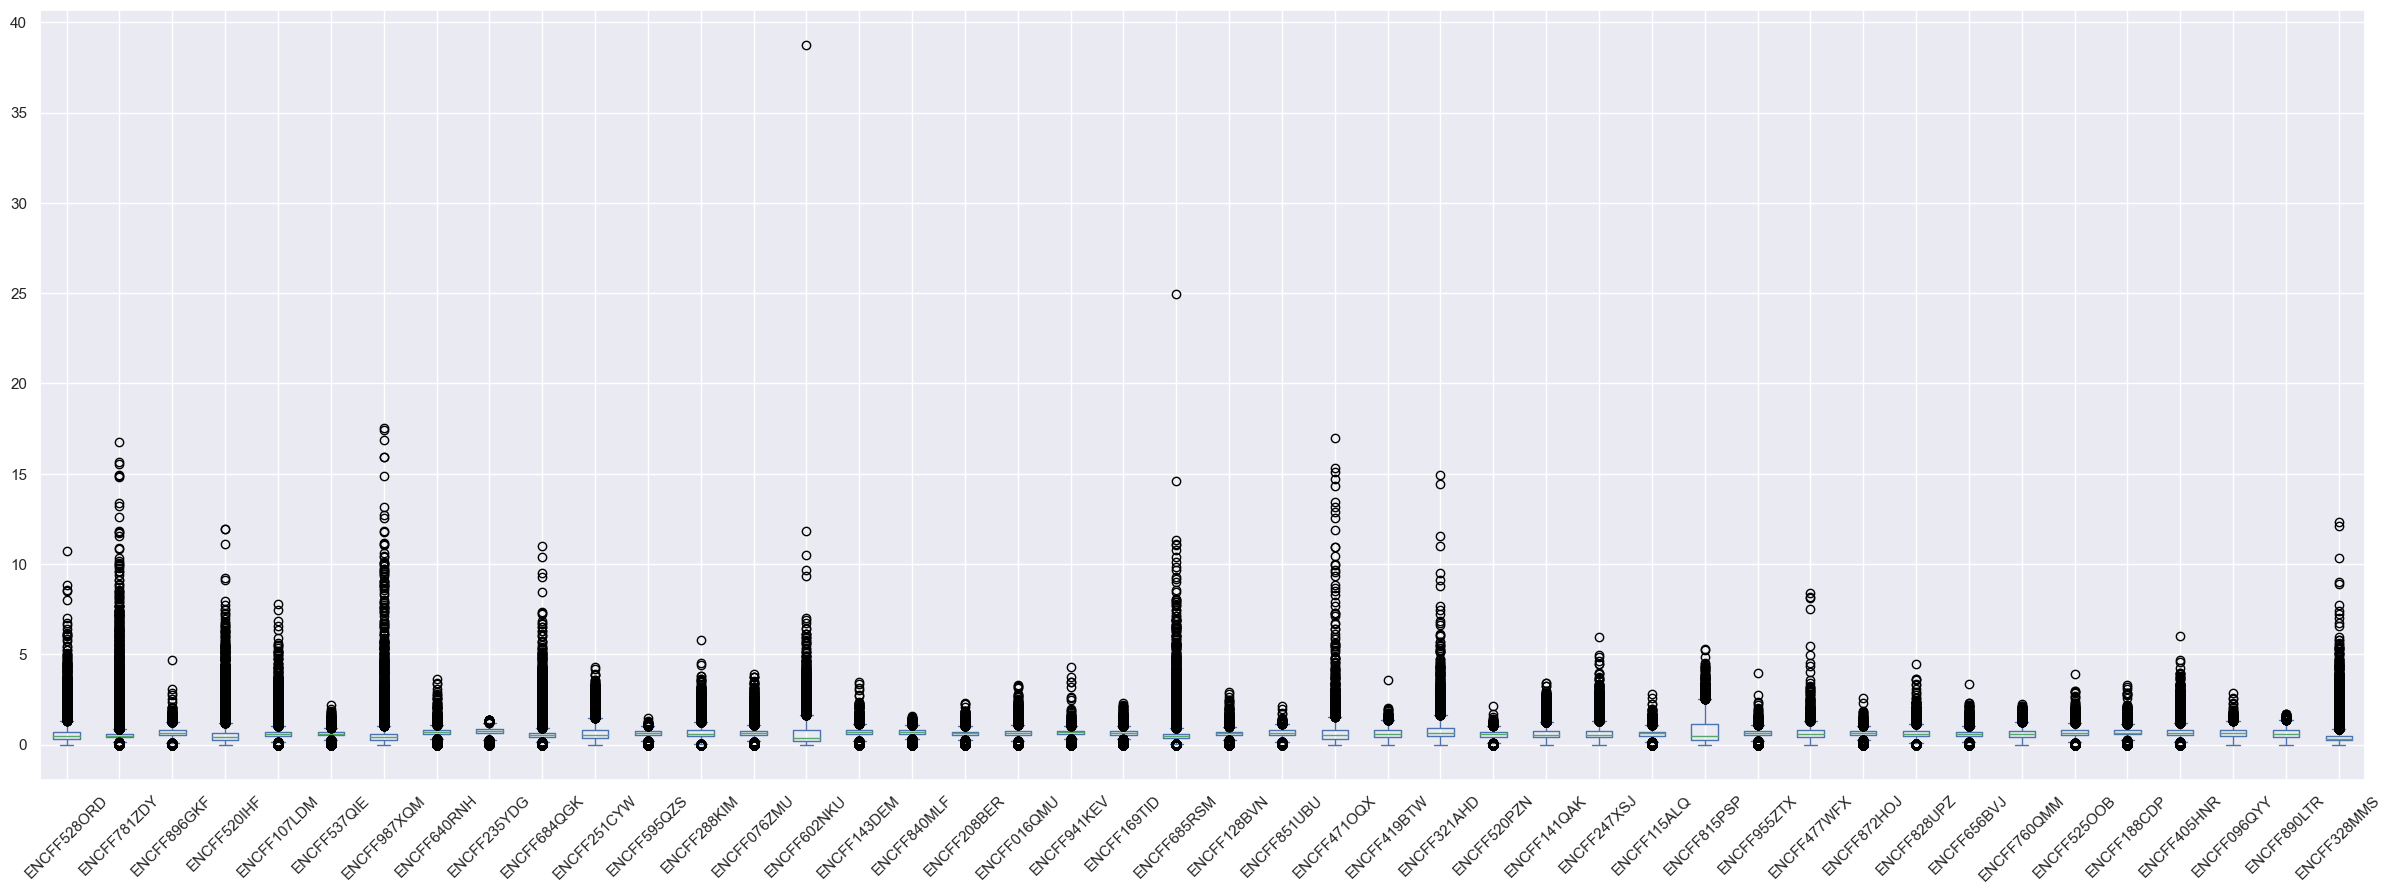

In [16]:
sample_list = [filter_bigwig[filter_bigwig['Experiment target']== (filter_bigwig['Experiment target'].unique()[i])].iloc[0, 1] for i in range(44)]
df_temp = df[sample_list]
df_temp.plot(kind='box', figsize=(30, 10), rot=45)

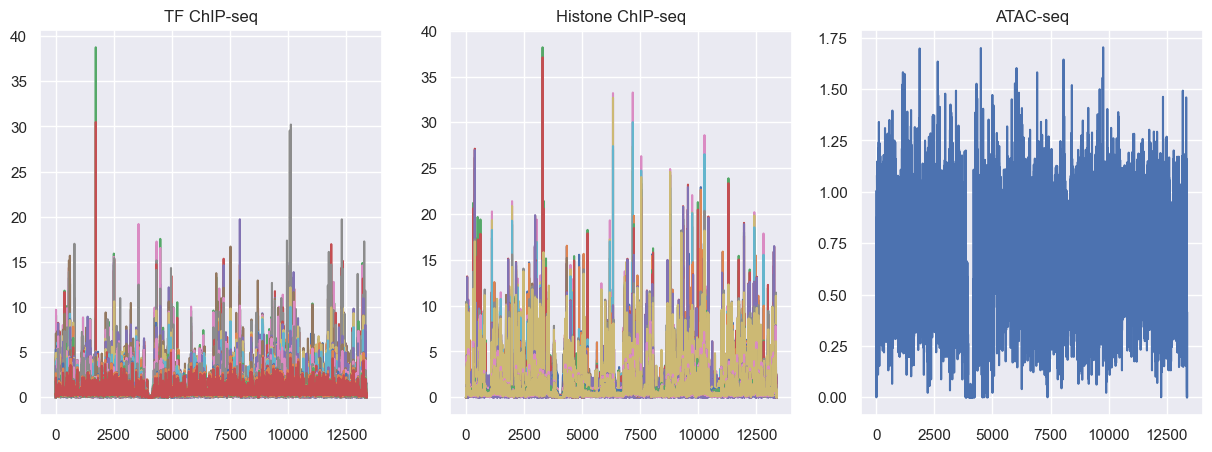

In [17]:
fig1, axs1 = plt.subplots(1,3, figsize = (15,5))
for i in range(3):
    f = filter_bigwig[filter_bigwig['Assay']== (filter_bigwig['Assay'].unique()[i])].iloc[:, 1]
    temp = df[f]
    temp.plot(legend=False, ax=axs1[i])
    axs1[i].set_title(filter_bigwig['Assay'].unique()[i])

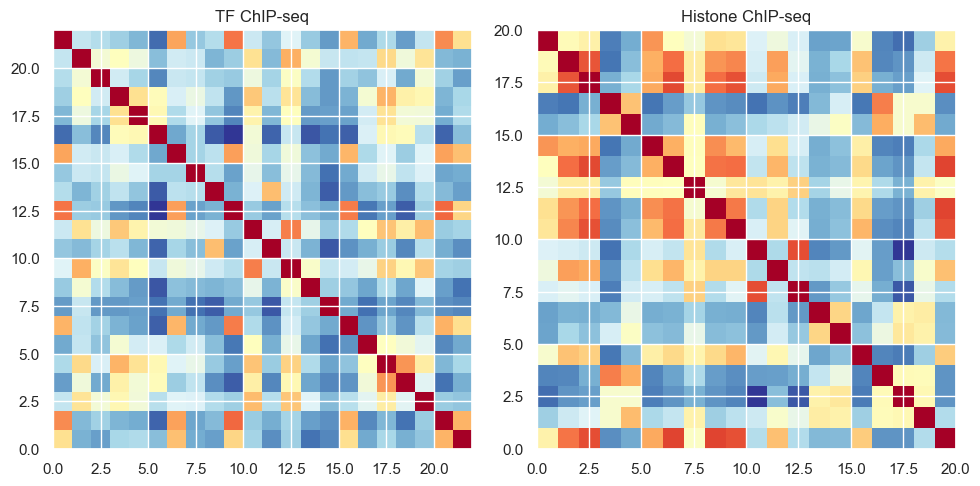

In [64]:
# remove x and y texts
from statsmodels.graphics.correlation import plot_corr

fig1, axs1 = plt.subplots(1,2, figsize = (10,5))
for i in range(2):
    assay = filter_bigwig['Assay'].unique()[i]
    sample_df = filter_bigwig[filter_bigwig['Assay']== assay]
    cell_type = sample_df['Biosample term name'].unique()
    sample_list = [sample_df[sample_df["Biosample term name"] == c].iloc[0,1] for c in cell_type]


    corr_matrix = df[sample_list].corr()
    plot_corr(corr_matrix, ax=axs1[i])

    axs1[i].set_title(filter_bigwig['Assay'].unique()[i])

# ***Q4 Answer:***
- From the three plots, we can tell that TF ChIP-seq and Histone ChIP-seq have more broad patterns, and ATAC-seq has a narrow pattern.

# ***Q5:***
- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


/Users/hcetin/Documents/Courses/QBIO 577 - Computational Molecular Biology Laboratory/qbio577_fall2022/hwutils.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


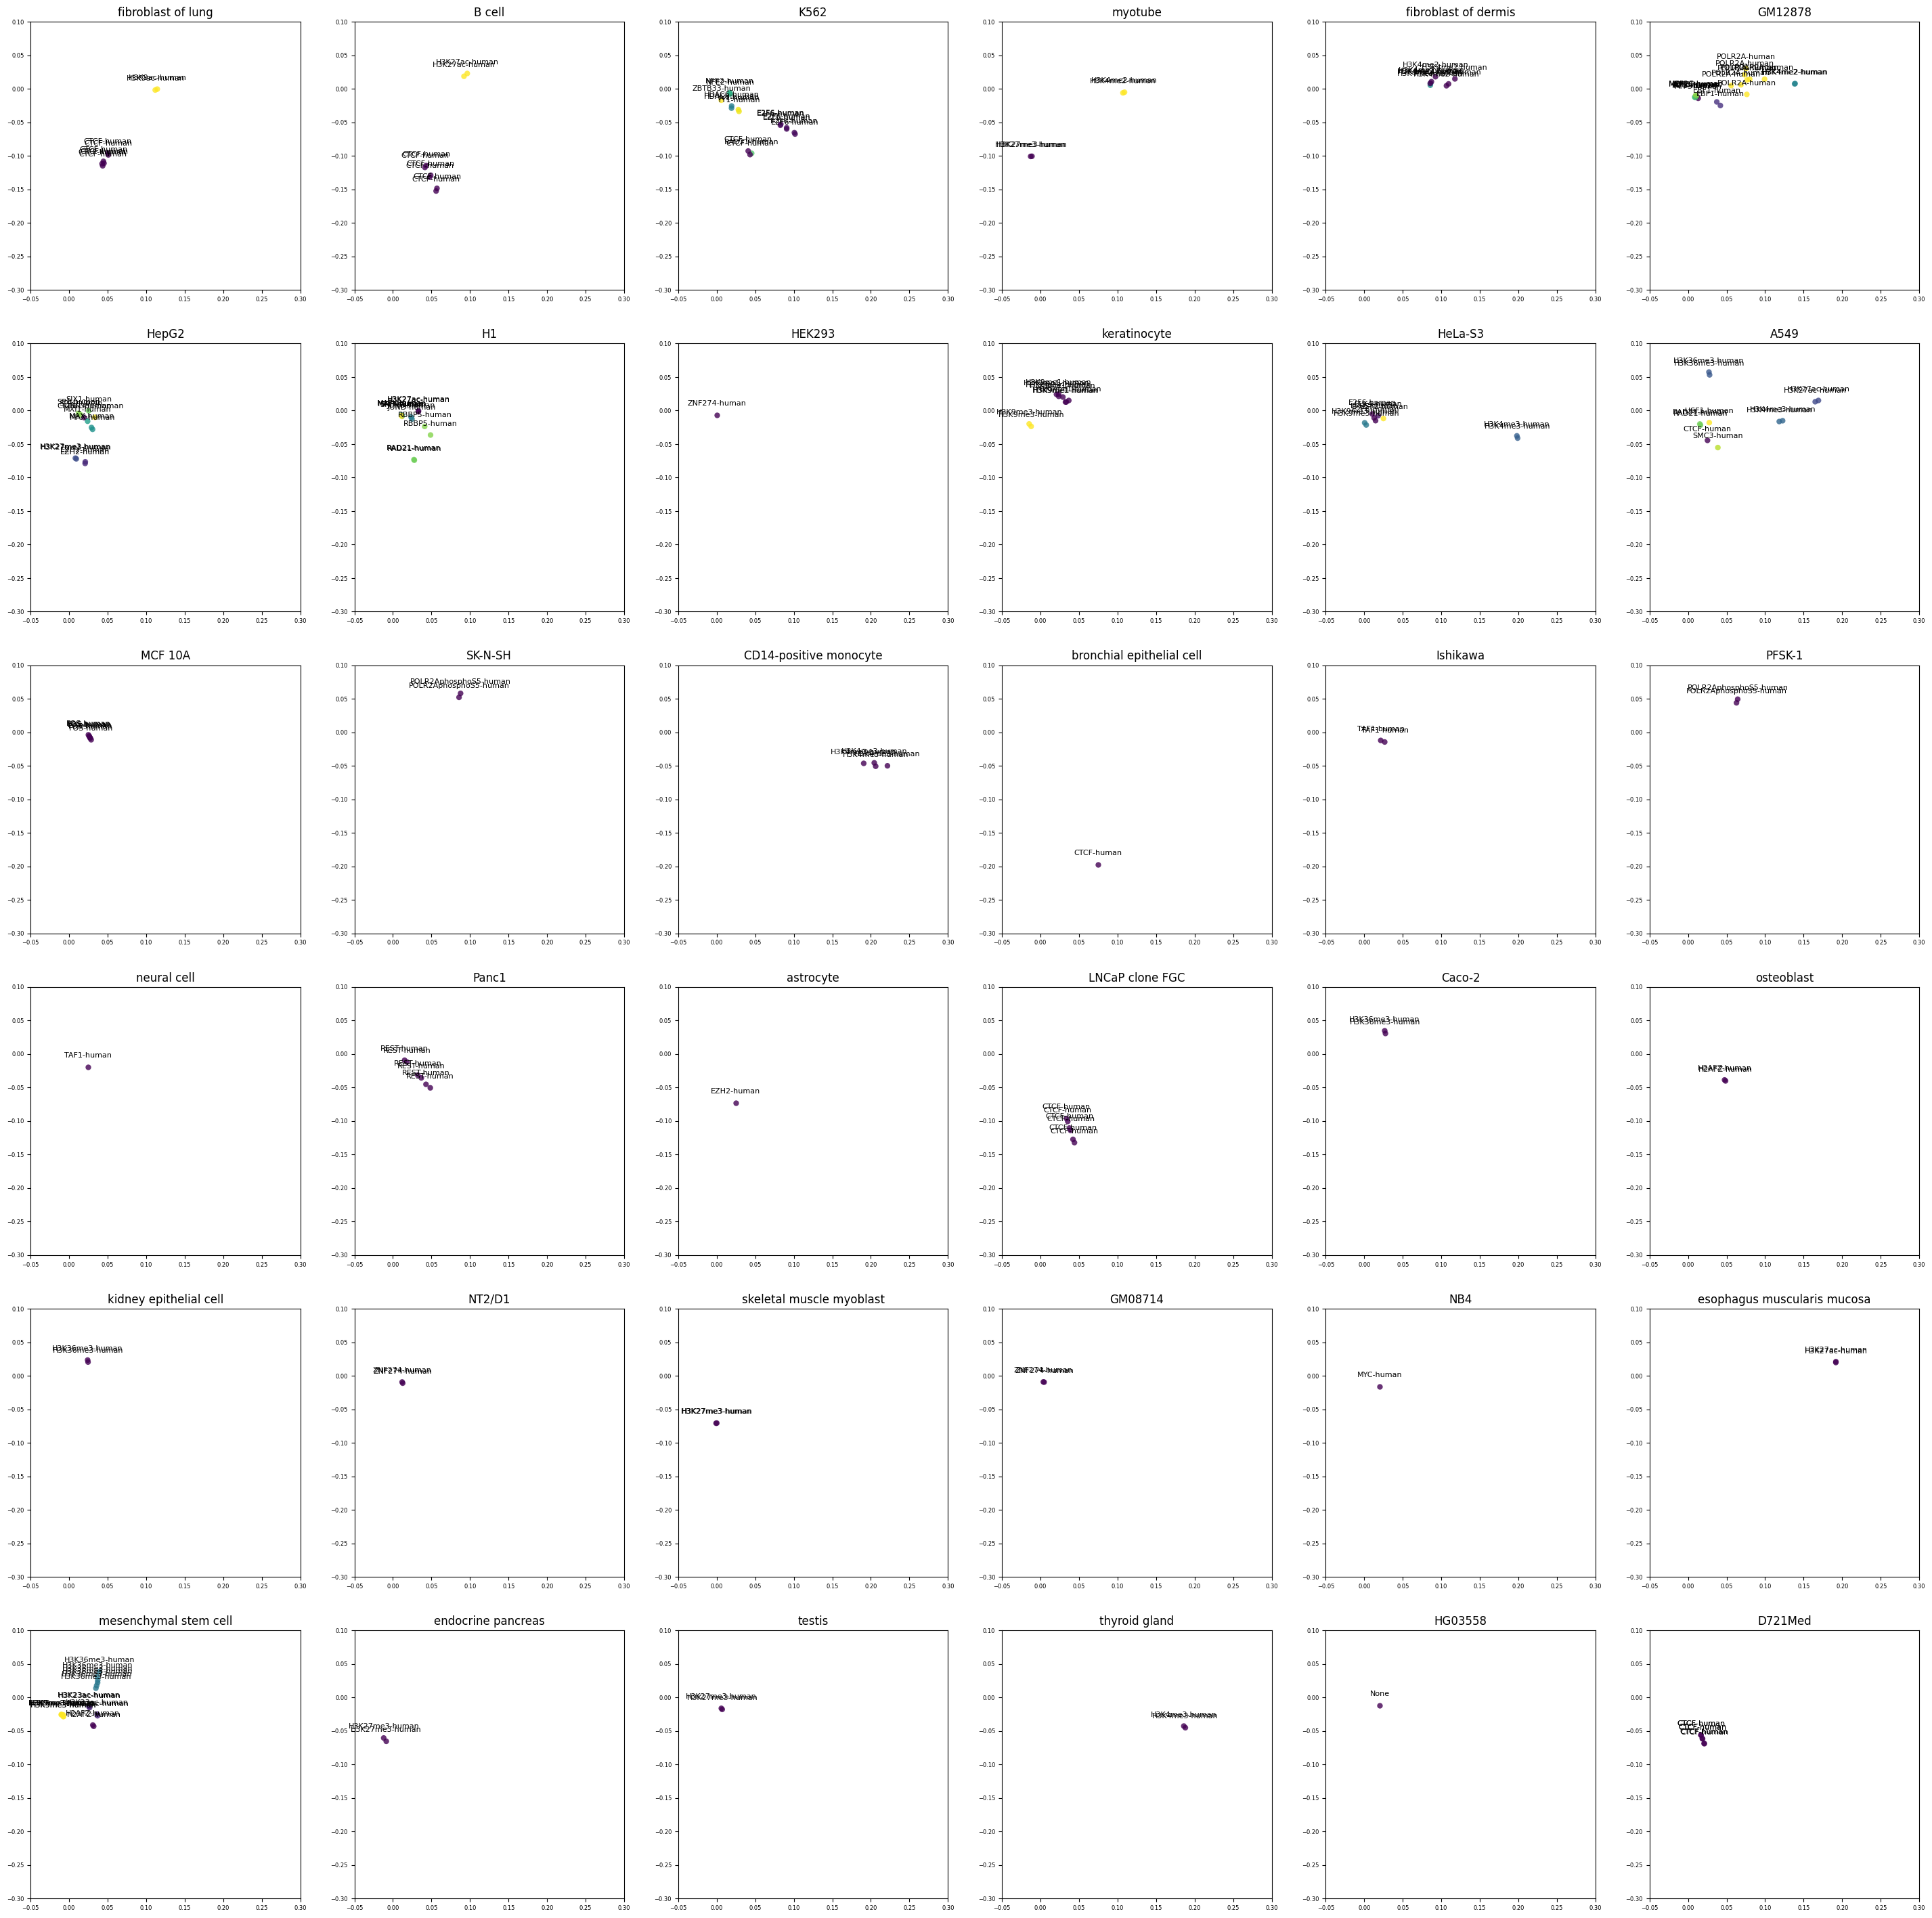

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [34]:
celltypes = bigwig_metadata[bigwig_metadata['File accession'].isin(df.keys())]['Biosample term name'].unique()

fig1, ax1 = plt.subplots(6,6, figsize=(36,36))
for i in range(0, len(celltypes)): # n=36

    plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Experiment target", label_display=True, figsize=(4,4), alpha=0.8,
        filter_label_column = "Audit ERROR", filterby="control extremely low read depth, extremely low read depth, missing control alignments",
        showonly_column = "Biosample term name", showonly=celltypes[i], showlabels=False, ax=ax1, i=i)
    
    ax1[np.floor(i/6).astype(int)][i%6].set_title(celltypes[i])
    ax1[np.floor(i/6).astype(int)][i%6].set_ylim(-0.3, 0.1)
    ax1[np.floor(i/6).astype(int)][i%6].set_xlim(-0.05, 0.3)
    ax1[np.floor(i/6).astype(int)][i%6].tick_params(axis='both', which='major', labelsize=6)
    

Text(0.5, 1.0, 'H3K27me3-human')

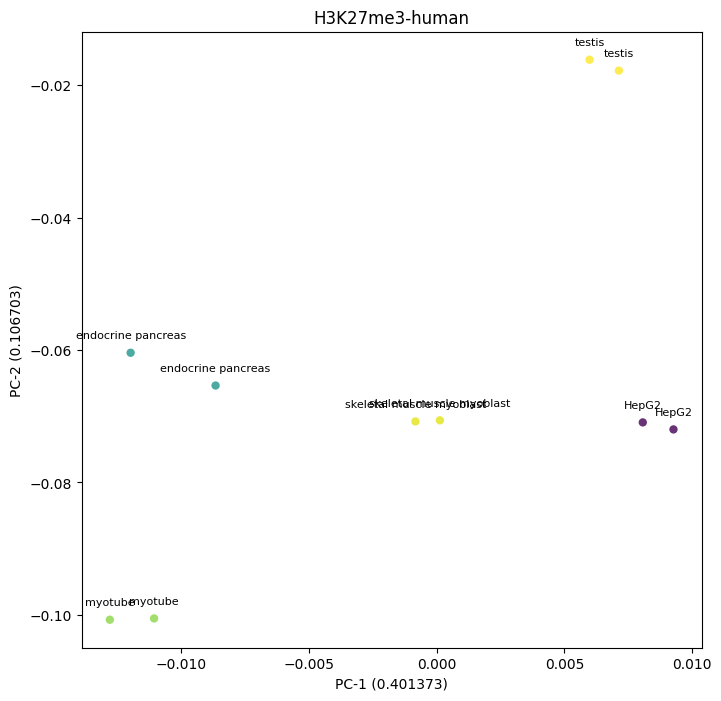

In [35]:
plt.close(fig1) #close the previous figure

plot_pca(pca,bigwig_metadata=bigwig_metadata, metadata_label_column="Biosample term name", label_display=True, figsize=(8,8), alpha=0.8,
    filter_label_column = "Audit ERROR", filterby="control extremely low read depth, extremely low read depth, missing control alignments",
    showonly_column = "Experiment target", showonly='H3K27me3-human')
plt.title('H3K27me3-human')

# ***Q5 Answer:***
- For the most of the cell types, it can be seen that the same type of experiment targets clustered together. For example, the CTCF (transcription factor) datapoints are in close proximity with each other compared to the H3K9ac (histone) datapoints for the lung-fibroblast cells. If we look at from the otherway, we can see that the H3K27me3 modification signal values show clusters for each cell type. This observation is biologically logical as we expect the signal values from same experiments to be close to each other.

# ***Q6:***
- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


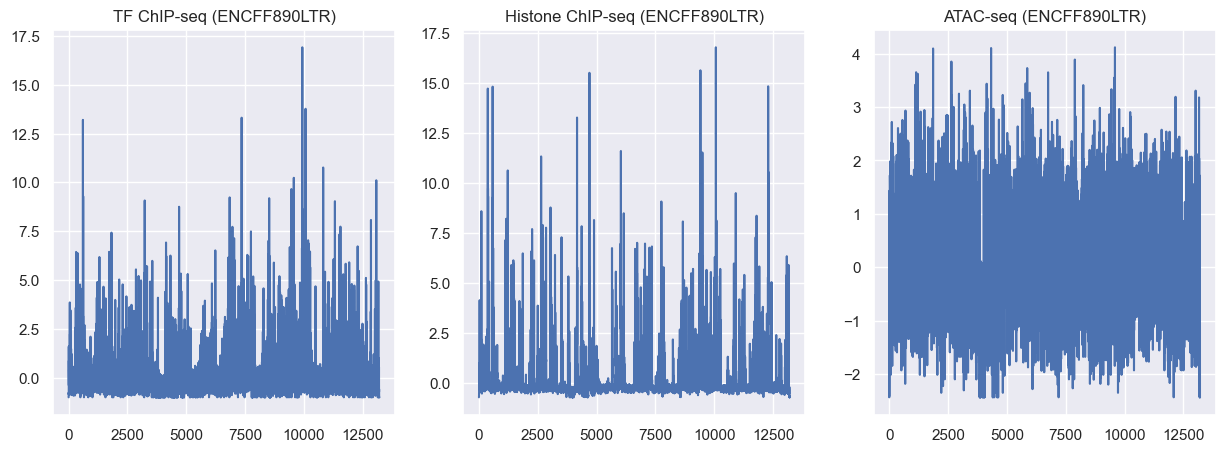

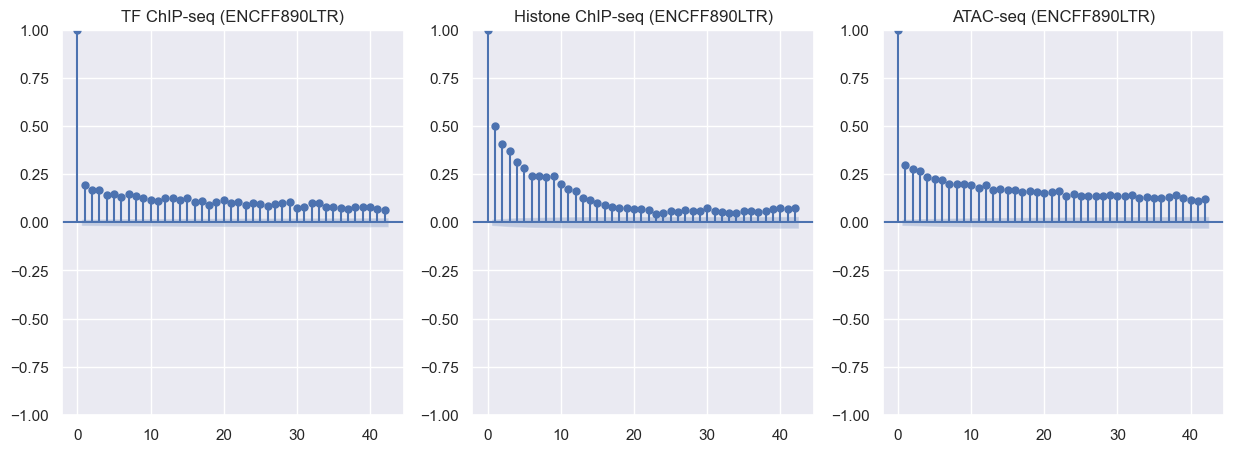

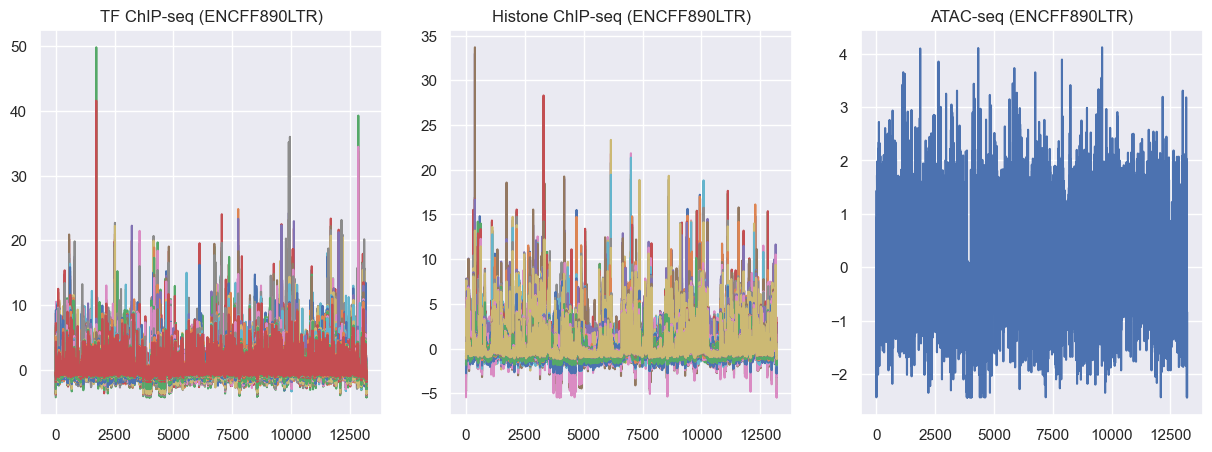

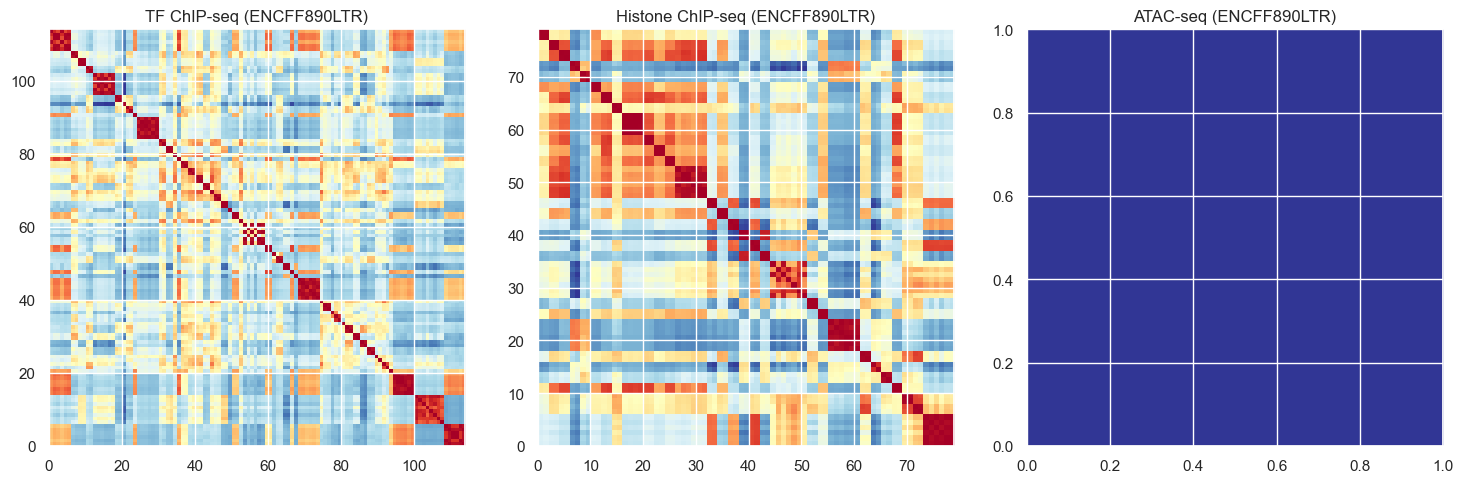

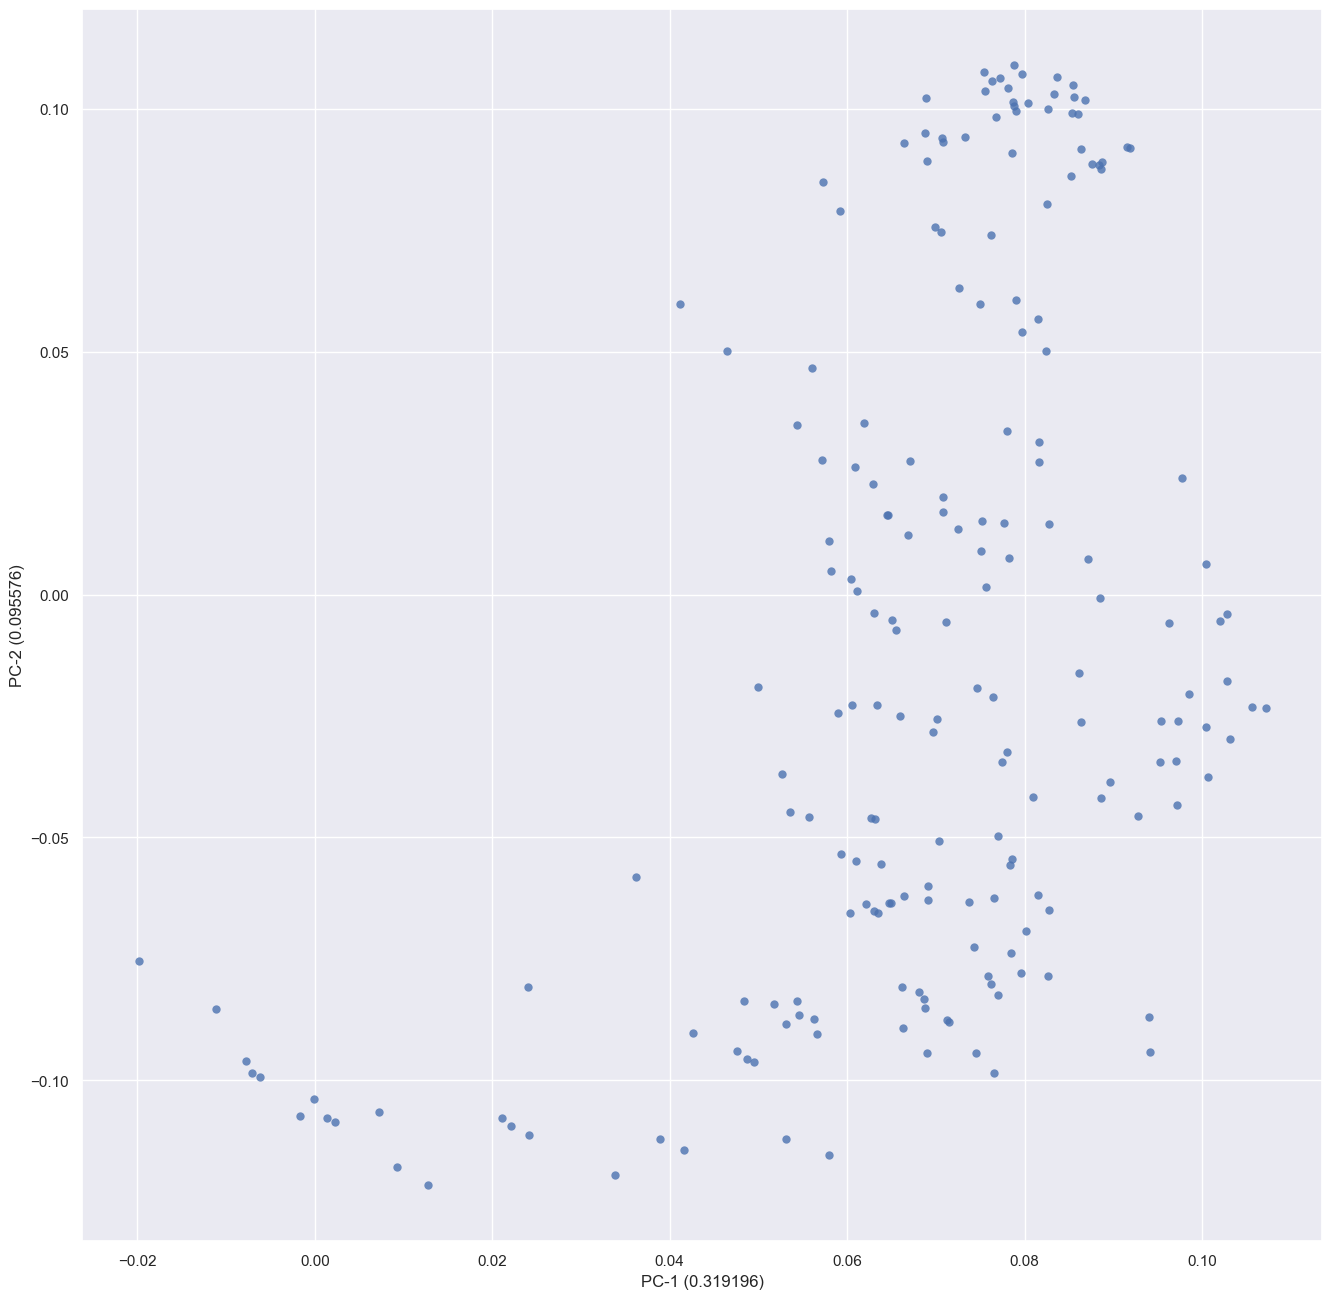

In [73]:
from sklearn.preprocessing import StandardScaler
# remove centromere from df
df_remove_centromere = df.drop(range(3980,4150), axis=0)
fig1, axs1 = plt.subplots(1, 3, figsize=(15, 5))
fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))
fig3, axs3 = plt.subplots(1, 3, figsize=(15, 5))
fig4, axs4 = plt.subplots(1, 3, figsize=(15, 5))


for i in range(3):
    assay = filter_bigwig['Assay'].unique()[i]
    sample_list = filter_bigwig[filter_bigwig['Assay']== assay].iloc[:, 1]
    
    # Normalize data for each assay
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df_remove_centromere[sample_list])
    df_normalized = pd.DataFrame(df_normalized)
    
    # Plot one samples from each assay
    axs1[i].plot(df_normalized.iloc[:,0])
    axs1[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")

    # Plot auto correlation
    plot_acf(df_normalized.iloc[:,0], ax=axs2[i])
    axs2[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")

    # Plot all samples from the same assay
    df_normalized.plot(legend=False, ax=axs3[i])
    axs3[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")

    # calculate correlation matrix  (fix to unique cell type, and plot a pca plot)
    corr_matrix = df_normalized.corr()
    plot_corr(corr_matrix, ax=axs4[i])

    axs4[i].set_title(f"{filter_bigwig['Assay'].unique()[i]} ({f})")


scaler = StandardScaler()
df_norm = scaler.fit_transform(df_remove_centromere)
df_norm = pd.DataFrame(df_norm)
pca = PCA().fit(df_norm)
plot_pca(pca, bigwig_metadata=bigwig_metadata, metadata_label_column=None, label_display=False, figsize=(16,16), alpha=0.8,
        filter_label_column=None,
        filterby=None)
    

1.0000757059580587

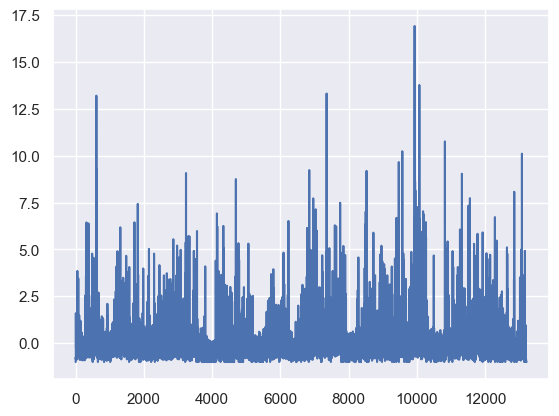

In [49]:
df_normalized.iloc[:,0]
plt.plot(df_normalized.iloc[:,0])
df_normalized.iloc[:,0].var()

# ***Q6 Answer***
- The importance of preprocessing depends on the situation. For datasets does matter as it 

# ***Q7:***

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


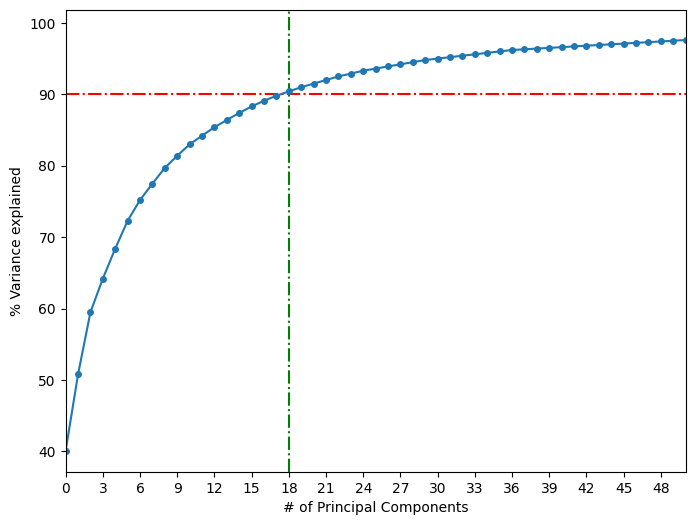

In [43]:
X = df.loc[:,~df.columns.isin(['chrom','start','end'])]
pca = PCA().fit(X)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

plt.figure(figsize=(8,6))
plt.ylabel("% Variance explained")
plt.xlabel("# of Principal Components")
plt.xlim(0,50)
plt.xticks(range(0,50,3))
plt.axhline(y=90, color='r', linestyle='-.')
plt.axvline(x=18, color='g', linestyle='-.')
plt.plot(var, marker='o', markersize=4)


> Need at least 18 PCs to explain 90% of the variance in the data. 

# ***Q8:*** 
- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


In [6]:
from sklearn.manifold import MDS

X = df.loc[:,~df.columns.isin(['chrom','start','end'])]
mds = MDS(random_state=0)
X_transform = mds.fit_transform(X)
print(X_transform)

le = sklearn.preprocessing.LabelEncoder()
le = le.fit(labels)
labels_transformed = le.transform(labels)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

fig, ax = plt.subplots(figsize=(15,15))
s = ax.scatter(X_transform[0],X_transform[1], c=labels_transformed)
# legend1 = ax.legend(*s.legend_elements(num=len(le.classes_)),
#                     ncol=3, loc="upper left")

# for i in range(0,len(le.classes_)):
#   legend1.get_texts()[i].set_text(le.classes_[i])

# # display labels for data points on the plot
# for idx, (x,y) in enumerate(zip(pca.components_[0],pca.components_[1])):
#     label = labels[idx]
#     if label == "ATAC-seq":
#       plt.annotate(label, # this is the text
#                   (x,y), # these are the coordinates to position the label
#                   textcoords="offset points", # how to position the text
#                   xytext=(0,10), # distance from text to points (x,y)
#                   ha='center',
#                   fontsize=8) # horizontal alignment can be left, right or center


# ***Q9:***
- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


# ***Q9 Answer:***
- non-negative matrix factorization is not very helpful for this dataset, as the dataset has too many confounders (different experiemntal pipelines, different cell types), it is very hard to use a basic element to represent each features, which is genes here. 